**Import Necessary libraries**

In [1]:
#import pandas library
import pandas as pd

#import the numpy library
import numpy as np

#import the matplotlib library
import matplotlib.pyplot as plt

#import the seaborn library
import seaborn as sns

**Read and Load Datasets from the provided CSV files**

In [2]:

#load both files and read with the necessary encoding parameter
df = 'AviationData.csv'
aviation_data = pd.read_csv(df, encoding='ISO-8859-1')
us_state_codes = pd.read_csv('USState_Codes.csv')

<ipython-input-2-27343f72e20c>:3: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  aviation_data = pd.read_csv(df, encoding='ISO-8859-1')


In [4]:
# Display the first few rows of each dataset to understand their structures
aviation_data.head(), us_state_codes.head()

(         Event.Id Investigation.Type Accident.Number  Event.Date  \
 0  20001218X45444           Accident      SEA87LA080  1948-10-24   
 1  20001218X45447           Accident      LAX94LA336  1962-07-19   
 2  20061025X01555           Accident      NYC07LA005  1974-08-30   
 3  20001218X45448           Accident      LAX96LA321  1977-06-19   
 4  20041105X01764           Accident      CHI79FA064  1979-08-02   
 
           Location        Country   Latitude  Longitude Airport.Code  \
 0  MOOSE CREEK, ID  United States        NaN        NaN          NaN   
 1   BRIDGEPORT, CA  United States        NaN        NaN          NaN   
 2    Saltville, VA  United States  36.922223 -81.878056          NaN   
 3       EUREKA, CA  United States        NaN        NaN          NaN   
 4       Canton, OH  United States        NaN        NaN          NaN   
 
   Airport.Name  ... Purpose.of.flight Air.carrier Total.Fatal.Injuries  \
 0          NaN  ...          Personal         NaN                  2

In [16]:
#display the first five rows of the DataFrame named
us_state_codes.head()

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


**Data Cleaning**

In [5]:
# Handling missing values
# Drop rows where there are missing values in critical columns for risk analysis
columns_to_check = ['Aircraft.damage', 'Make', 'Model', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
aviation_data.dropna(subset=columns_to_check, inplace=True)

In [6]:
# Impute missing 'Number.of.Engines' with the mode
mode_engines = aviation_data['Number.of.Engines'].mode()[0]
aviation_data['Number.of.Engines'].fillna(mode_engines, inplace=True)

In [7]:
# Convert 'Event.Date' to datetime format for easier manipulation
aviation_data['Event.Date'] = pd.to_datetime(aviation_data['Event.Date'])

In [8]:
# Extract state abbreviations from the 'Location' field
aviation_data['State'] = aviation_data['Location'].str.extract(r', (\w\w)$')

In [9]:
# Data integration: Merge with state codes to standardize state names
aviation_data = aviation_data.merge(us_state_codes, left_on='State', right_on='Abbreviation', how='left')

In [10]:
# Replace state abbreviations with full state names for clarity in visualizations
aviation_data['State'] = aviation_data['US_State'].fillna(aviation_data['State'])

In [11]:
# Drop unnecessary columns after the merge
aviation_data.drop(columns=['Abbreviation', 'US_State'], inplace=True)

In [12]:
# Verify and view the cleaned data
print(aviation_data.head())

         Event.Id Investigation.Type Accident.Number Event.Date  \
0  20001218X45444           Accident      SEA87LA080 1948-10-24   
1  20001218X45447           Accident      LAX94LA336 1962-07-19   
2  20001218X45448           Accident      LAX96LA321 1977-06-19   
3  20041105X01764           Accident      CHI79FA064 1979-08-02   
4  20001218X45446           Accident      CHI81LA106 1981-08-01   

          Location        Country Latitude Longitude Airport.Code  \
0  MOOSE CREEK, ID  United States      NaN       NaN          NaN   
1   BRIDGEPORT, CA  United States      NaN       NaN          NaN   
2       EUREKA, CA  United States      NaN       NaN          NaN   
3       Canton, OH  United States      NaN       NaN          NaN   
4       COTTON, MN  United States      NaN       NaN          NaN   

  Airport.Name  ... Air.carrier Total.Fatal.Injuries Total.Serious.Injuries  \
0          NaN  ...         NaN                  2.0                    0.0   
1          NaN  ...     

# **EDA**

In [13]:
# Check if 'State' column exists and create it if necessary
if 'State' not in aviation_data.columns:
    # Assuming 'Location' field contains state information in the form 'City, State'
    aviation_data['State'] = aviation_data['Location'].str.extract(r', (\w\w)$')

    # Merge with the US state codes to standardize state names
    aviation_data = aviation_data.merge(us_state_codes, left_on='State', right_on='Abbreviation', how='left')
    aviation_data['State'] = aviation_data['US_State'].fillna(aviation_data['State'])
    aviation_data.drop(columns=['Abbreviation', 'US_State'], inplace=True)

# Now, reattempt to aggregate data by Aircraft Model and State
model_state_summary = aviation_data.groupby(['Make', 'Model', 'State']).agg(
    Total_Accidents=('Event.Id', 'count'),
    Fatal_Accidents=('Total.Fatal.Injuries', lambda x: (x > 0).sum()),
    Serious_Accidents=('Total.Serious.Injuries', lambda x: (x > 0).sum())
).reset_index()




In [31]:
# Filter out models with very few data points to ensure statistical significance
filtered_summary = model_state_summary[model_state_summary['Total_Accidents'] > 10]

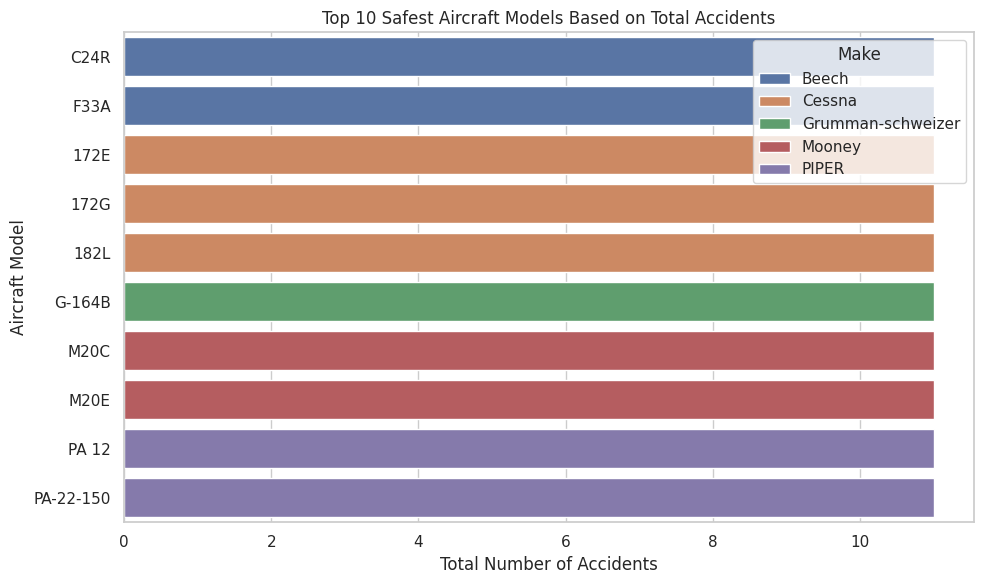

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up visualization style
sns.set(style="whitegrid")

# Aggregating data by Aircraft Model and State
model_state_summary = aviation_data.groupby(['Make', 'Model', 'State']).agg(
    Total_Accidents=('Event.Id', 'count'),
    Fatal_Accidents=('Total.Fatal.Injuries', lambda x: (x > 0).sum()),
    Serious_Accidents=('Total.Serious.Injuries', lambda x: (x > 0).sum())
).reset_index()

# Filter out models with very few data points to ensure statistical significance
filtered_summary = model_state_summary[model_state_summary['Total_Accidents'] > 10]

# Total Accidents by Aircraft Model - Top 10 safest models
safest_models = filtered_summary.groupby(['Make', 'Model']).Total_Accidents.sum().nsmallest(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=safest_models, x='Total_Accidents', y='Model', hue='Make', dodge=False)
plt.title('Top 10 Safest Aircraft Models Based on Total Accidents')
plt.xlabel('Total Number of Accidents')
plt.ylabel('Aircraft Model')
plt.legend(title='Make')
plt.tight_layout()

plt.show()

<ipython-input-21-339e4ee9e7d5>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


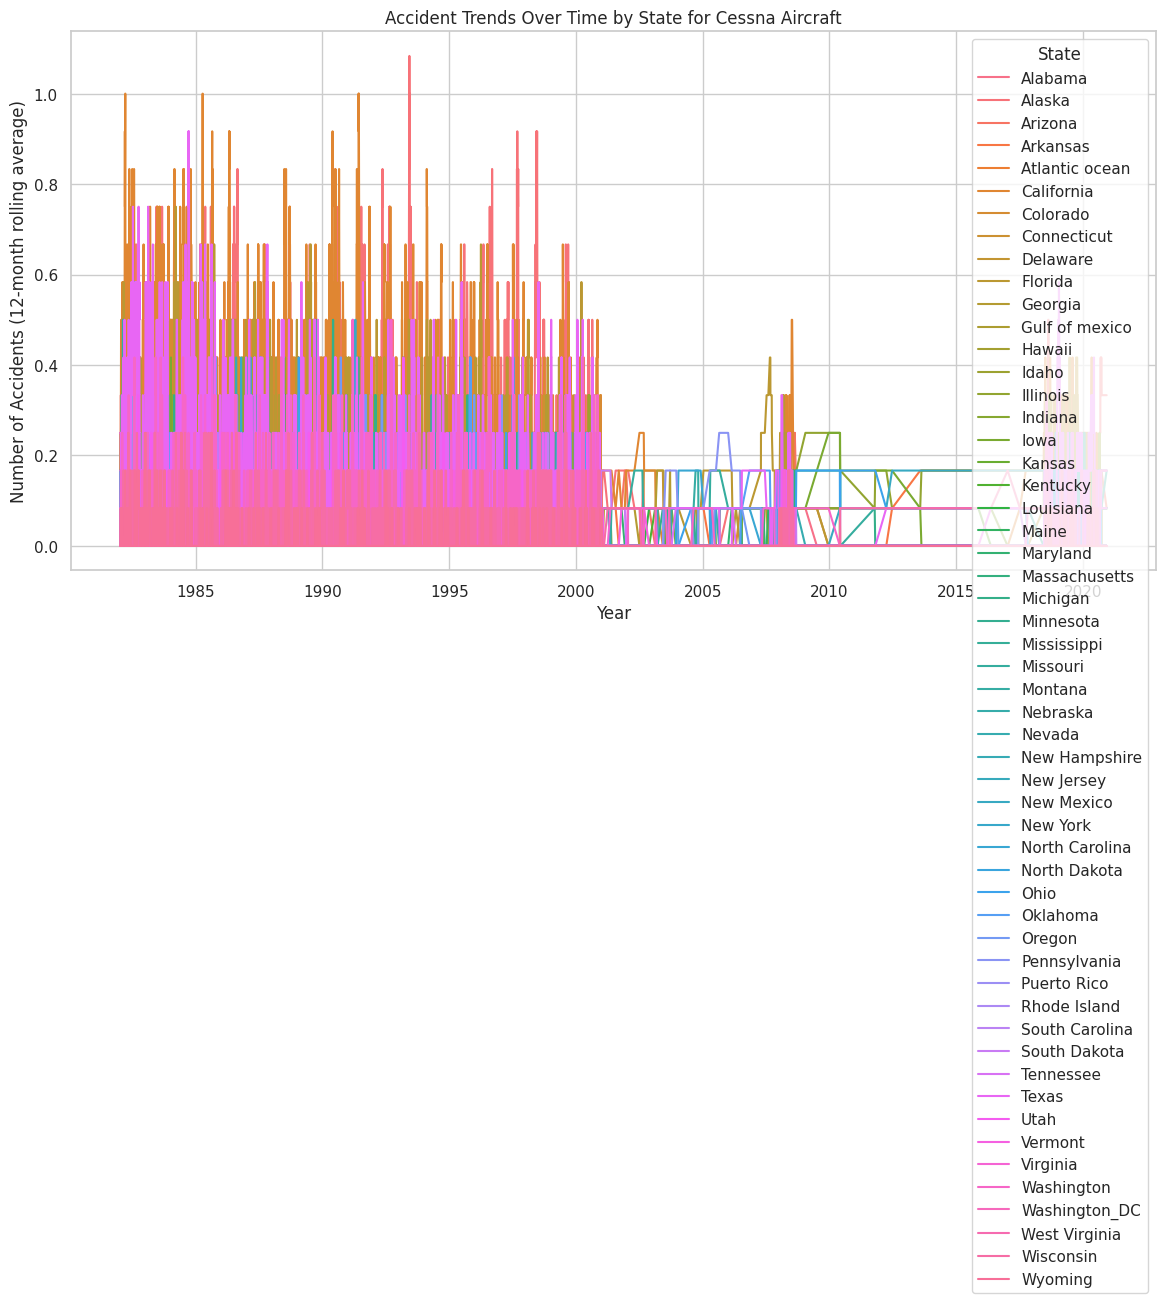

In [21]:
# Trends in Accidents Over Time by State for a Specific Model
# Select a common model to analyze trends
common_model = 'Cessna'
state_trends = aviation_data[aviation_data['Make'] == common_model].groupby(['Event.Date', 'State']).size().unstack(fill_value=0).rolling(window=12).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=state_trends, dashes=False)
plt.title(f'Accident Trends Over Time by State for {common_model} Aircraft')
plt.xlabel('Year')
plt.ylabel('Number of Accidents (12-month rolling average)')
plt.legend(title='State')
plt.tight_layout()

plt.show()

In [30]:
#save for me my cleaned data in a folder in my desktop

cleaned_data = aviation_data
cleaned_data.to_csv('cleaned_data.csv', index=False)

